In [285]:
%pylab inline
from astropy.io import ascii
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


/Users/sumits2k/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [286]:
tabnonpar = ascii.read("SFH_nonparametric.csv")
tabnonpar

age_5559,SFR_5559,SFR_5559_lower,SFR_5559_upper,age_2768,SFR_2768,SFR_2768_lower,SFR_2768_upper,age_4589,SFR_4589,SFR_4589_lower,SFR_4589_upper,age_2272,SFR_2272,SFR_2272_lower,SFR_2272_upper
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7.0,2.805301469,1.924388032,3.870422334,7.0,0.026871016,0.020519688,0.032353934,7.0,0.019028994,0.004420896,0.032284825,7.0,0.020797865,0.011647041,0.028812223
7.4772,2.805301469,1.924388032,3.870422334,7.4772,0.026871016,0.020519688,0.032353934,7.4772,0.019028994,0.004420896,0.032284825,7.4772,0.020797865,0.011647041,0.028812223
8.0,2.557045217,1.566949456,4.013154327,8.0,0.024268191,0.013056999,0.044073827,8.0,0.023904186,0.007786247,0.069333359,8.0,0.020770629,0.010636885,0.036934683
8.41182821,1.829041725,1.047394451,3.247636364,8.41295485,0.025780505,0.010468289,0.055395873,8.41182821,0.043505253,0.011607563,0.166872281,8.41272558,0.022753317,0.009018913,0.054321541
8.82365641,1.606295216,0.958543437,2.739943847,8.82590969,0.029062501,0.010392243,0.074774415,8.82365641,0.124691374,0.021557167,0.70851965,8.82545117,0.027848958,0.009408316,0.067706756
9.23548462,2.169113737,1.241045789,3.601944396,9.23886454,0.034377901,0.010790162,0.118251227,9.23548462,1.174755176,0.069269332,3.829472711,9.23817675,0.039456334,0.01044601,0.112032807
9.64731283,4.102752402,2.652850268,5.694333511,9.65181939,0.057471375,0.012155218,0.219240401,9.64731283,10.45083918,5.830641093,15.984388,9.65090233,0.445498287,0.06453332,2.166796121
10.05914103,6.561043336,5.18591365,7.842313275,10.06477424,16.13372962,13.53755454,18.67769776,10.05914103,10.32569154,8.223229878,13.23611734,10.06362792,9.684444097,8.208922307,10.97527874
10.12972211,6.239822973,3.210173111,10.04703374,10.13535531,29.41057099,16.92027474,41.95219126,10.12972211,8.180266377,3.750407111,15.70819277,10.13420899,8.213800018,3.657780647,14.68750166


### Defining functions and reading in data

In [289]:
import scipy.interpolate as interp
import scipy.integrate as integ

def dtd_cc(t):
    #Delay-time distribution for core-collapse supernovae from Zapartas et al 2017
    #Case of single stars, Eq A1 in paper
    t_Myr = t/1.0e6
    return 1.0e6*np.piecewise(t_Myr, [t_Myr<3., (t_Myr>=3.) & (t_Myr<25.), (t_Myr>=25.) & (t_Myr<=48),t_Myr>48],\
                     [0, lambda t: (1.0e-9)*(-2.83 + (8.7*np.log10(t)) - 2.07*(np.log10(t)**2))*(1/t), \
                      lambda t: (1.0e-8)*(-4.85 + (6.55*np.log10(t)) - 1.92*(np.log10(t)**2))*(1/t), \
                      0])

def dtd_cc_bin(t):
    t_Myr = t/1.0e6
    #I removed the pre-factor of 1.0e6 because that was meant to out in units in ccSN/Msun/Myr
    #which was okay when I was just integrating the DTD, but here I integrate the SFR and DTD 
    #together so that turns out to be incorrect
    return np.piecewise(t_Myr, [t_Myr<=3., (t_Myr>=3.) & (t_Myr<25.), (t_Myr>=25.) & (t_Myr<=48),\
                      (t_Myr>=48.) & (t_Myr<=200.),t_Myr>=200.],\
                     [0, lambda t: (1.0e-9)*(-2.65 + (7.51*np.log10(t)) - 0.98*(np.log10(t)**2))*(1/t), \
                      lambda t: (1.0e-8)*(-0.89 + (1.73*np.log10(t)) - 0.51*(np.log10(t)**2))*(1/t), \
                      lambda t: (1.0e-8)*(3.46 - (2.98*np.log10(t)) + 0.65*(np.log10(t)**2))*(1/t),
                      0])

def dtd_ia(t):
    t_Myr = t/1.0e6
    # Type Ia SN DTD
    #Eq 13, Maoz & Mannucci 2012, PASA 2019 447
    return np.piecewise(t_Myr, [t_Myr<40., (t_Myr>=40.) & (t_Myr<=100.0e4), t_Myr>100.0e4], \
                     [0, lambda t: (4.0e-10)*(t)**(-1.0), 0])

For each galaxy's star-formation history ($\dot{M}(t)$, in units $M_{\odot}$/yr), you can calculate the SN rate $R_{SN}$ as in Eq 10 of [Maoz & Badenes 2010](https://arxiv.org/abs/1003.3031) 

\begin{equation}
R_{SN} = \int_0^{t_0} \dot{M}(t-\tau) \Psi(\tau) d\tau
\end{equation}

where $\Psi(\tau)$ is the delay-time distribution (DTD) for either core-collapse or Type Ia SN. For each age bin (e.g. $t_{lo,1}-t_{up,1}, t_{lo,2}-t_{up,2}, t_{lo,3}-t_{up,3}, ...$) and corresponding star-formation rates in the bin ($\dot{M}_1$, $\dot{M}_2$, $\dot{M}_3$,...) we can spread this integral out as 
\begin{equation}
R_{SN} = \int_{t_{lo,1}}^{t_{up,1}} \dot{M}_1(t-\tau) \Psi(\tau) d\tau + \int_{t_{lo,2}}^{t_{up,2}} \dot{M}_2(t-\tau) \Psi(\tau) d\tau + \int_{t_{lo,3}}^{t_{up,3}} \dot{M}_3(t-\tau) \Psi(\tau) d\tau + ...
\end{equation}

Since the SFR in each age bin is a constant, we just take it out of the integral and calculate the integral over the DTD
\begin{equation}
R_{SN} = \dot{M}_1 \int_{t_{lo,1}}^{t_{up,1}} \Psi(\tau) d\tau + \dot{M}_2 \int_{t_{lo,2}}^{t_{up,2}} \Psi(\tau) d\tau + \dot{M}_3 \int_{t_{lo,3}}^{t_{up,3}} \Psi(\tau) d\tau + ...
\end{equation}

(Note: I think you can get away with just evaluating the DTD at the central age bin value (i.e. $\int_{t_{lo,1}}^{t_{up,1}} \Psi(\tau) d\tau \approx \Psi_1 (t_{up,1}-t_{lo,1})$). Can check this later.)

In [290]:
galaxy = ["5559","2768","4589","2272"]
for g in galaxy:
    #Reading age limits, sfrs  from Vic's star-formation histories
    logagelims = np.concatenate(([0], tabnonpar["age_{}".format(g)].data)) #Adding 0 to the first bin
    sfr = tabnonpar["SFR_{}".format(g)].data
    sfr_low = tabnonpar["SFR_{}_lower".format(g)].data
    sfr_up = tabnonpar["SFR_{}_upper".format(g)].data
    ages = 10**logagelims

    #integral over the DTD for CC
    intDTD_cc = np.array([integ.quad(dtd_cc_bin, ages[j], ages[j+1])[0] for j in range(len(ages[:-1]))])
    #integral over the DTD for Ia
    intDTD_ia = np.array([integ.quad(dtd_ia, ages[j], ages[j+1])[0] for j in range(len(ages[:-1]))])
    #SN rates = SFR*int(DTD)
    Rsn_cc = np.dot(sfr.T, intDTD_cc)
    Rsn_ia = np.dot(sfr.T, intDTD_ia)

    print("Rates in SN/yr")
    print("Core collapse Rate for {}: ".format("NGC"+g), Rsn_cc)
    print("Thermonuclear Rate for {}: ".format("NGC"+g), Rsn_ia)
    print("Ia/CC Fraction for {}: ".format("NGC"+g), Rsn_ia/Rsn_cc)
    print("\n")


Rates in SN/yr
Core collapse Rate for NGC5559:  0.03440684118283839
Thermonuclear Rate for NGC5559:  0.007513507685876253
Ia/CC Fraction for NGC5559:  0.21837249301525177


Rates in SN/yr
Core collapse Rate for NGC2768:  0.00033224464989700886
Thermonuclear Rate for NGC2768:  0.008112989144890429
Ia/CC Fraction for NGC2768:  24.41872020333613


Rates in SN/yr
Core collapse Rate for NGC4589:  0.0002731535087537892
Thermonuclear Rate for NGC4589:  0.008930632707434731
Ia/CC Fraction for NGC4589:  32.69455606914603


Rates in SN/yr
Core collapse Rate for NGC2272:  0.00026633522250217367
Thermonuclear Rate for NGC2272:  0.00442654502664802
Ia/CC Fraction for NGC2272:  16.620201357752798




### Parametric Star-formation histories

In [104]:
tabtemp = ascii.read("parametric.csv")
cols = tuple(tabtemp[0])
data = tabtemp[1:]
tabpar = Table(data,\
               names=("Host", "logM", "elogM_up", "elogM_lo", "logtau", "elogtau_up", "elogtau_lo",\
                           "tage", "etage_up", "etage_lo"),\
              dtype=[str, float, float, float, float, float, float, float, float, float])

In [105]:
tabpar

Host,logM,elogM_up,elogM_lo,logtau,elogtau_up,elogtau_lo,tage,etage_up,etage_lo
str31,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC 2768,11.141,0.0004,-0.0004,-0.1398,0.0007,-0.0007,8.2583,0.0119,-0.0123
NGC 5559,10.384,0.0003,-0.0003,-0.8821,0.0007,-0.0007,0.9082,0.0014,-0.0014
NGC 2207,10.9193,0.0013,-0.0021,-0.4041,0.0006,-0.0005,1.734,0.0033,-0.0058
UGC 6934,10.2437,0.1079,-0.1056,0.1091,0.4351,-0.3104,5.8138,3.6194,-2.4832
NGC 5714,10.299,0.0004,-0.0004,0.6266,0.0006,-0.0005,13.6136,0.0018,-0.0033
NGC 1032,10.9244,0.0017,-0.0017,-0.5007,0.0045,-0.0044,3.4723,0.0217,-0.0223
NGC 4589,10.9768,0.0002,-0.0002,-0.3871,0.0004,-0.0004,4.8459,0.0037,-0.0037
NGC 1129,10.8301,0.0034,-0.0033,-0.0792,0.0417,-0.0534,12.6501,0.2636,-0.2813
CGCG 170-011,10.4002,0.0081,-0.0087,-0.8378,0.0911,-0.1273,2.3249,0.1213,-0.1254


### Checking parameteric and non-parametric solutions.



/Users/sumits2k/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


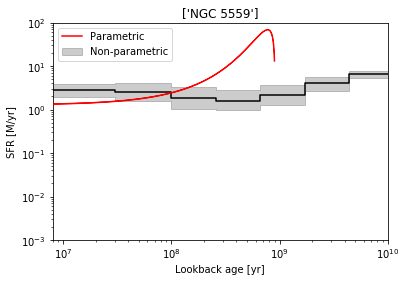

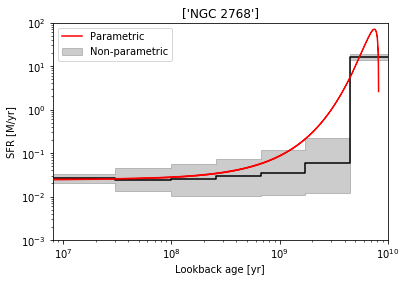

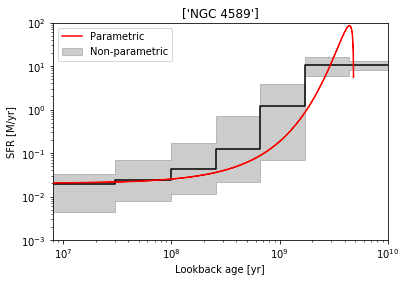

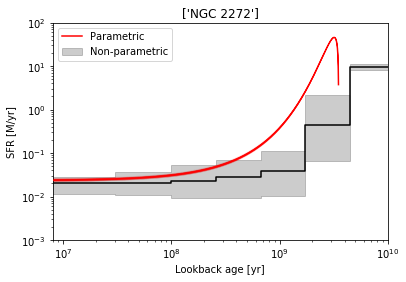

In [295]:
def sfr(t, MF=1.0e11, tau=1.0e9, tage=1.0e10):
    """
    Star formation rate in units of Msun/yr
    Eq in Sec 4.2 of vic's paper
    """
    f_tt = lambda tt: tt*np.exp(-tt/tau)
    int_f_tt = integ.quad(f_tt, 0, tage)[0]
    return MF*f_tt(t)/int_f_tt

def plot_rand_sfrs(gal, n=100):
    """
    Plot randomized SFHs based on errors in the parameters. 
    Turns out the errors are quite small, and therefore can be ignored
    """
    #Generate random values of mass, tau and age from the uncertainties in Vic's table
    r_logM = np.random.normal(loc=gal["logM"], scale=gal["elogM_up"], size=n)
    r_logtau = np.random.normal(loc=gal["logtau"], scale=gal["elogtau_up"], size=n)
    r_tage = 1.0e9*np.random.normal(loc=gal["tage"], scale=gal["etage_up"], size=n)
    
    #calculate the star-formation history for each random value and plot it.
    for logM, logtau, tage in zip(r_logM, r_logtau, r_tage):
        arr_sfr = sfr(t, MF=10**logM, tau=10**(logtau+9), tage=tage)
        plt.plot(tage-t, arr_sfr, ls="-", color="r", lw=0.2, alpha=0.2)
    

#nonparametric solutions
galaxy = ["5559","2768","4589","2272"]
t = np.logspace(7,11,10000)

for g in galaxy:  
    plt.figure()
    #PARAMETRIC SFRs
    tab = tabpar[(tabpar["Host"]=="NGC {}".format(g))]
    arr_sfr = sfr(t, MF=10**tab["logM"], tau=10**(tab["logtau"]+9), tage=tab["tage"]*1.0e9)
    tl = tab["tage"]*1.0e9 - t #lookback time
    plt.title(tab["Host"].data)
    plt.plot(tl, arr_sfr, ls='-', zorder=10, color="r", label="Parametric")
    plot_rand_sfrs(tab)
    
    #NONPARAMETRIC SFRs
    #Reading age limits, sfrs  from Vic's star-formation histories
    logagelims = np.concatenate(([0], tabnonpar["age_{}".format(g)].data)) #Adding 0 to the first bin
    sfrnonpar = tabnonpar["SFR_{}".format(g)].data
    sfrnonpar_low = tabnonpar["SFR_{}_lower".format(g)].data
    sfrnonpar_up = tabnonpar["SFR_{}_upper".format(g)].data
    ages = 10**logagelims
    x_axis = np.vstack((ages[:-1], ages[1:])).T.flatten()
    y_axis = np.repeat(sfrnonpar,2)
    y_axis_errup = np.repeat(sfrnonpar_up,2)
    y_axis_errlo = np.repeat(sfrnonpar_low,2)
    plt.plot(x_axis, y_axis, "k-")
    plt.fill_between(x_axis, y_axis_errlo, y_axis_errup, color="k", alpha=0.2, label="Non-parametric")

    #Frame specs
    plt.xlabel("Lookback age [yr]")
    plt.ylabel("SFR [M/yr]")
    plt.xlim(8.0e6,1.0e10)
    plt.yscale("log")
    plt.ylim(1.0e-3, 1.0e2)
    plt.xscale("log")
    plt.legend()
    plt.show()

So these show the star-formation histories for the 4 galaxies for which we also have non-parametric star-formation histories. NGC 5559 is the one that has a clear discrepancy in the parametric and non-parametric form. 

Below, I calculate the rates using the same equation as before, except now using the functional form of the star-formation history $\dot{M}(t)$
\begin{equation}
R_{SN} = \int_0^{t_{age}} \dot{M}(t-\tau) \Psi(\tau) d\tau
\end{equation}
where $\dot{M}(t)$ is given by :-
\begin{equation}
\dot{M}(t) = M_F \bigg [\int_0^{t_{age}} t^{'} \mathrm{e}^{-t^{'}/\tau} \mathrm{d}t^{'} \bigg]^{-1} t\mathrm{e}^{-t/\tau} \mathrm{d}t
\end{equation}


In [294]:
def rsn(gal):
    """
    SN rate as a function of parametric star-formation history
    and DTD
    """
    tage = gal["tage"]*1.0e9
    MF = 10**gal["logM"]
    tau = 10**(gal["logtau"]+9)
    #print(tage, MF, tau)
    
    f_t = lambda t: t*np.exp(-t/tau)
    int_f_t = integ.quad(f_t, 0, tage)[0]
    f_sfr = lambda t: np.piecewise(t, [t<=0, t>0], [0, MF*f_t(t)/int_f_t])
    f_sfr_dtdcc = lambda tt: dtd_cc_bin(tt)*f_sfr(tage-tt)
    f_sfr_dtdia = lambda tt: dtd_ia(tt)*f_sfr(tage-tt)
    return integ.quad(f_sfr_dtdcc, 0, tage)[0], integ.quad(f_sfr_dtdia, 0, tage)[0]

galaxy = ["5559","2768","4589","2272"]
for g in galaxy:  
    tab = tabpar[(tabpar["Host"]=="NGC {}".format(g))]
    rcc, ria = rsn(tab)
    print("Rates in SN/yr")
    print("Core collapse Rate for {}: ".format("NGC"+g), rcc)
    print("Thermonuclear Rate for {}: ".format("NGC"+g), ria)
    print("Ia/CC Fraction for {}: ".format("NGC"+g), ria/rcc)
    print("\n")

/Users/sumits2k/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  app.launch_new_instance()


Rates in SN/yr
Core collapse Rate for NGC5559:  0.01995298578214469
Thermonuclear Rate for NGC5559:  0.01706662695774343
Ia/CC Fraction for NGC5559:  0.8553420096663342


Rates in SN/yr
Core collapse Rate for NGC2768:  0.00032469163670961185
Thermonuclear Rate for NGC2768:  0.008436011442490194
Ia/CC Fraction for NGC2768:  25.981609899102345


Rates in SN/yr
Core collapse Rate for NGC4589:  0.00027550996971113036
Thermonuclear Rate for NGC4589:  0.009728103391221194
Ia/CC Fraction for NGC4589:  35.30944234584694


Rates in SN/yr
Core collapse Rate for NGC2272:  0.00032336179270052055
Thermonuclear Rate for NGC2272:  0.005744704028299613
Ia/CC Fraction for NGC2272:  17.76556215972007




So as expected, the rates of the last 3 galaxies are quite consistent with the results of the non-parametric star-formation histories, with rates agreeing to within 10-30$\%$. The big difference is NGC 5559, where the Type Ia rate is higher by almost a factor 2.5, and CC rate is lower by nearly a factor of 2. So with parametric SFH, one would think there's a 50-50 chance that 2001co was a thermonuclear or core-collapse progenitor, whereas the non-parametric solution suggests that its 5 times more likely that 2001co came from a core-collapse progenitor